In [1]:
#import the libraries

import matplotlib.pyplot as plt
import cmaps
from mpl_toolkits.basemap import Basemap
import numpy as np
import xarray as xr

In [2]:
#define two function needed next

#function for mark the longitude and latitude
def set_lonlat(_m, lon_list, lat_list, lon_labels, lat_labels, lonlat_size):
    lon_dict = _m.drawmeridians(lon_list, labels=lon_labels, color='none', fontsize=lonlat_size)
    lat_dict = _m.drawparallels(lat_list, labels=lat_labels, color='none', fontsize=lonlat_size)
    lon_list = []
    lat_list = []
    for lon_key in lon_dict.keys():
        try:
            lon_list.append(lon_dict[lon_key][1][0].get_position()[0])
        except:
            continue

    for lat_key in lat_dict.keys():
        try:
            lat_list.append(lat_dict[lat_key][1][0].get_position()[1])
        except:
            continue
    ax = plt.gca()
    ax.set_yticks(lat_list)
    ax.set_xticks(lon_list)
    ax.tick_params(labelcolor='none')
    ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

#interpolation function for the target depth
def zslice(var, z, depth, findlev=False):
     [N, Mp, Lp] = z.shape
     #
     # Find the grid position of the nearest vertical levels
     #
     var=np.array(var)
     a = np.where(z <= depth, 1, 0)
     levs = np.squeeze(np.sum(a, axis=0)) - 1
     levs = np.where(levs == N - 1, N - 2, levs)
     levs = np.where(levs == -1, 0, levs)
     levs = np.array(levs)

     # Do the interpolation
     z1 = np.zeros_like(z[0, :, :])
     z2 = np.zeros_like(z[0, :, :])
     v1 = np.zeros_like(z[0, :, :])
     v2 = np.zeros_like(z[0, :, :])

     for j in range(Mp):
         for i in range(Lp):
             k = levs[j, i]
             z1[j, i] = z[k + 1, j, i]
             z2[j, i] = z[k, j, i]
             v1[j, i] = var[k + 1, j, i]
             v2[j, i] = var[k, j, i]
     zmask = np.where(z2 > depth, np.nan, 1) 
     vnew = zmask * (((v1 - v2) * depth + v2 * z1 - v1 * z2) / (z1 - z2))
     return vnew

In [3]:
#read variables from the ncfile
filepath=r'C:/Users/yt/Desktop/pom18_w/'
file=filepath+'pom18_initialts.nc'
z= xr.open_dataset(file,decode_times = False).h3.values
s=xr.open_dataset(file,decode_times = False).zz.values

file=filepath+'pom18.nc'
lon= xr.open_dataset(file,decode_times = False).lon.values
lat= xr.open_dataset(file,decode_times = False).lat.values
u= xr.open_dataset(file,decode_times = False).outU
v= xr.open_dataset(file,decode_times = False).outV
temp= xr.open_dataset(file,decode_times = False).outT
salt= xr.open_dataset(file,decode_times = False).outS

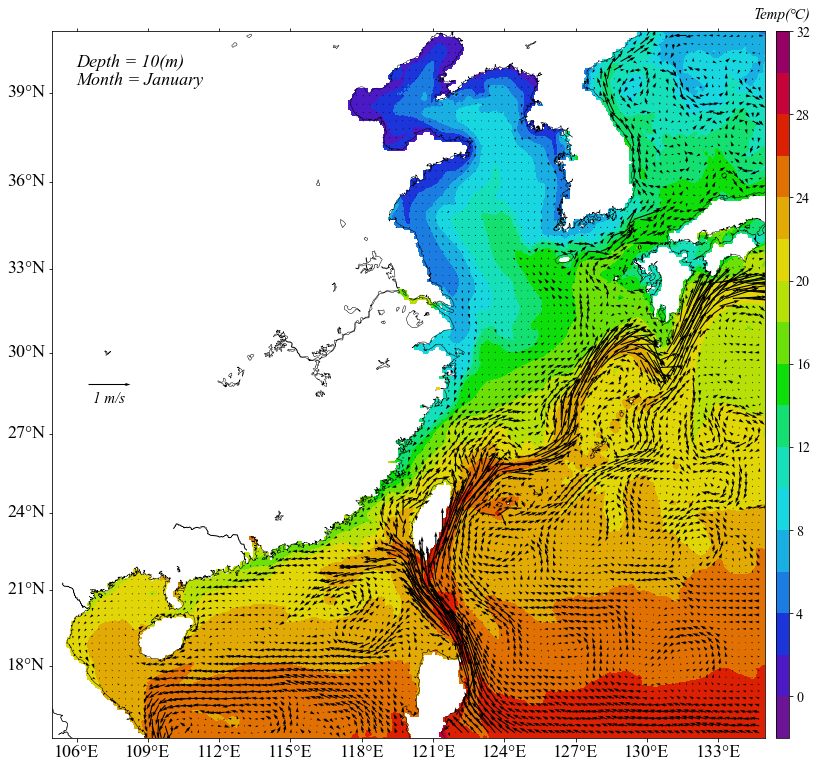

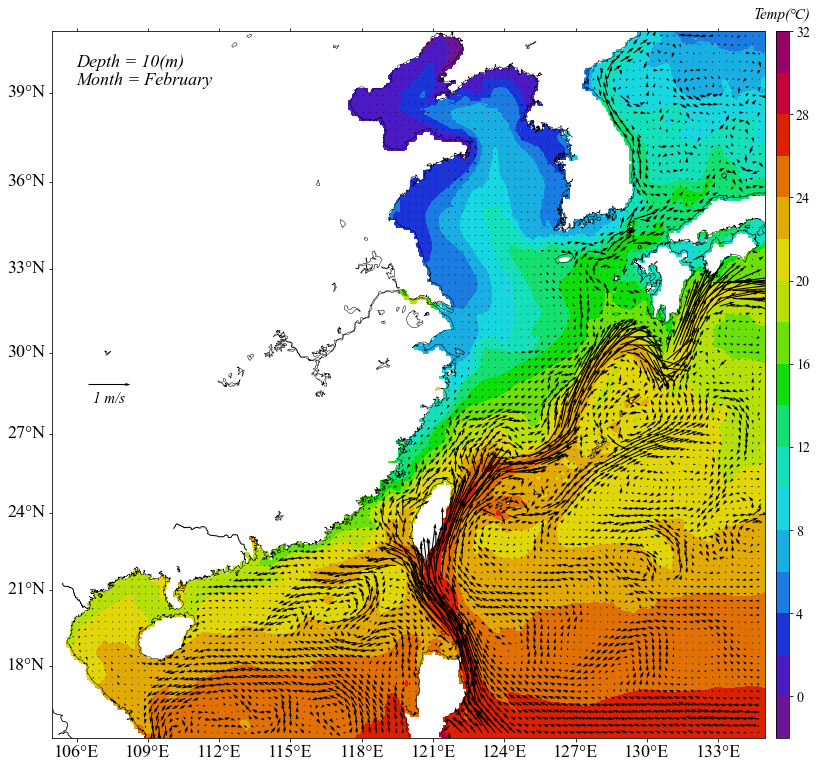

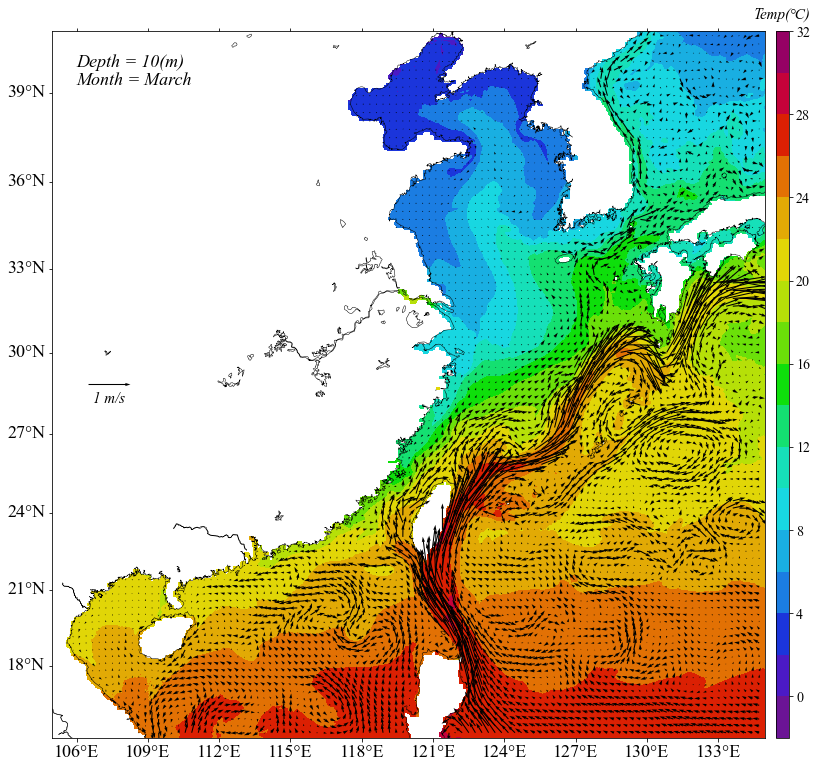

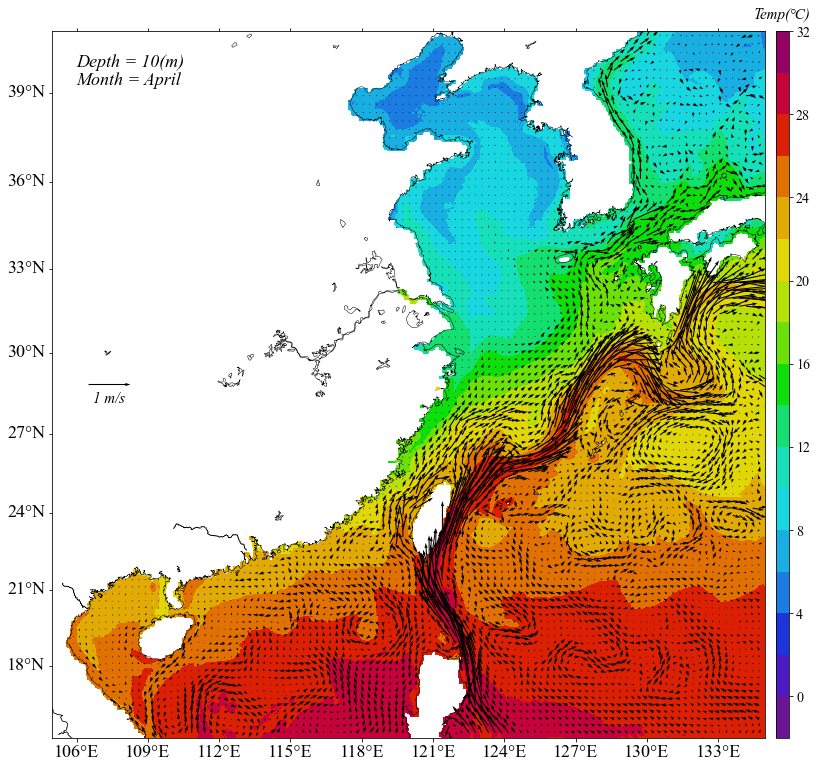

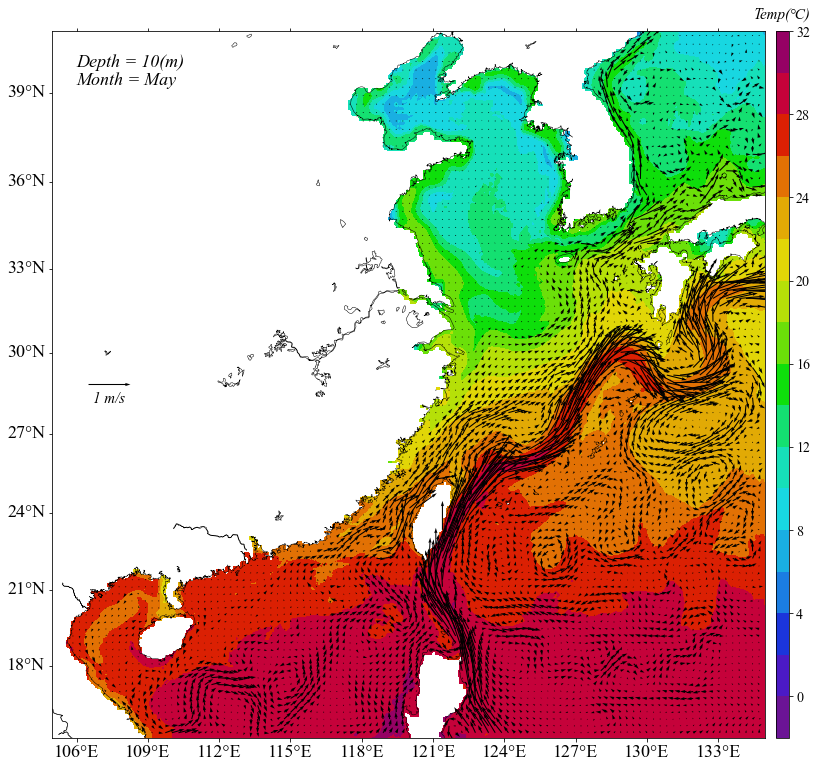

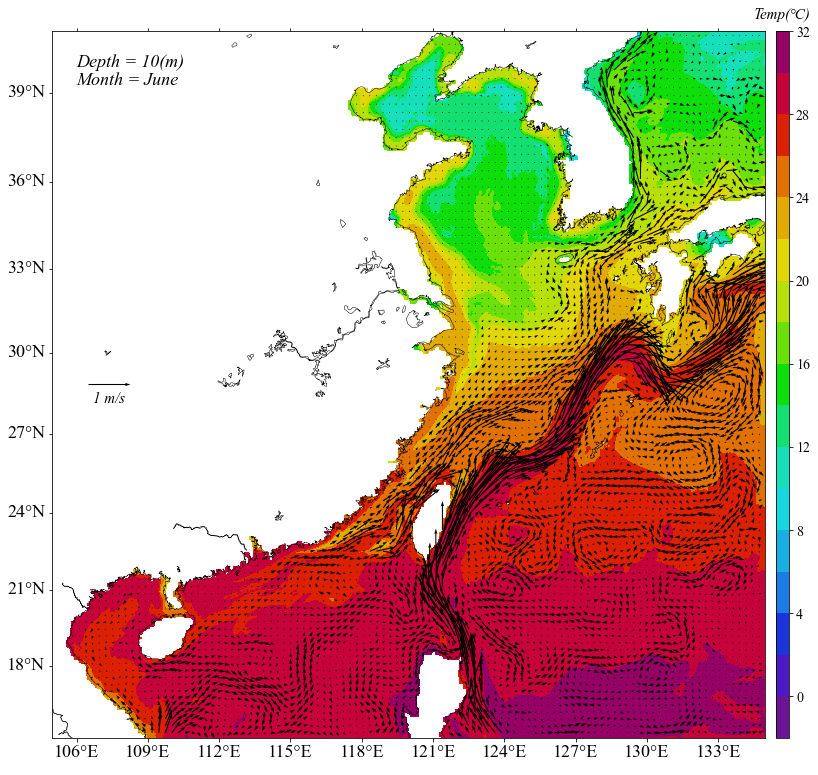

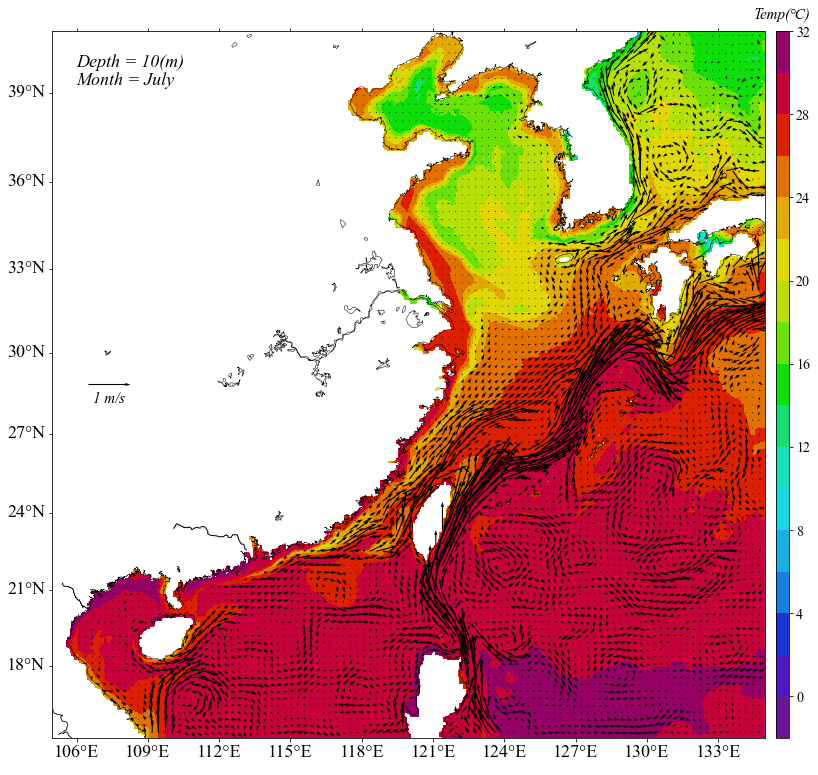

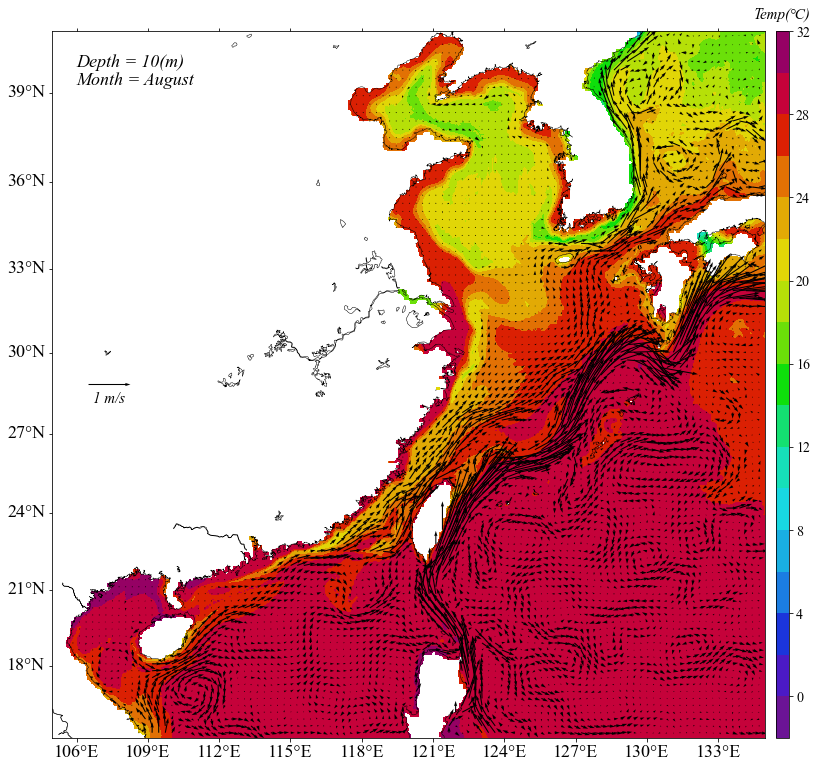

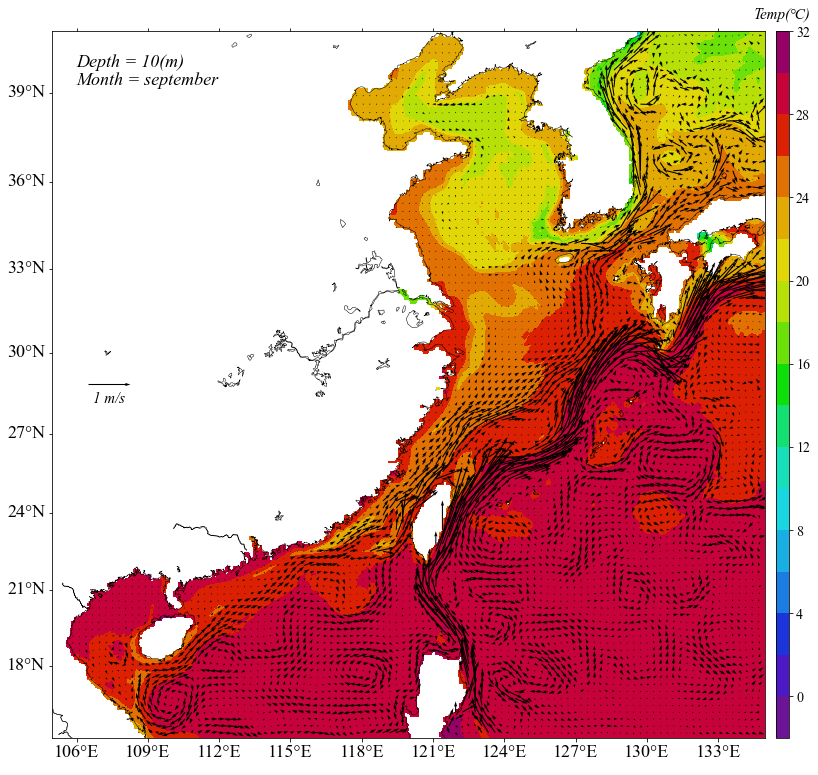

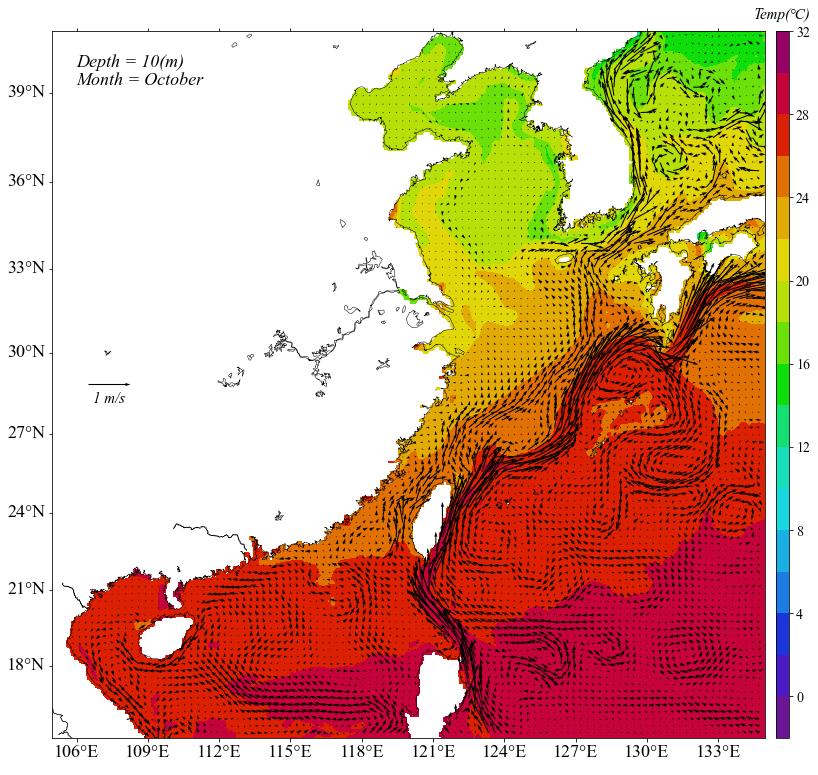

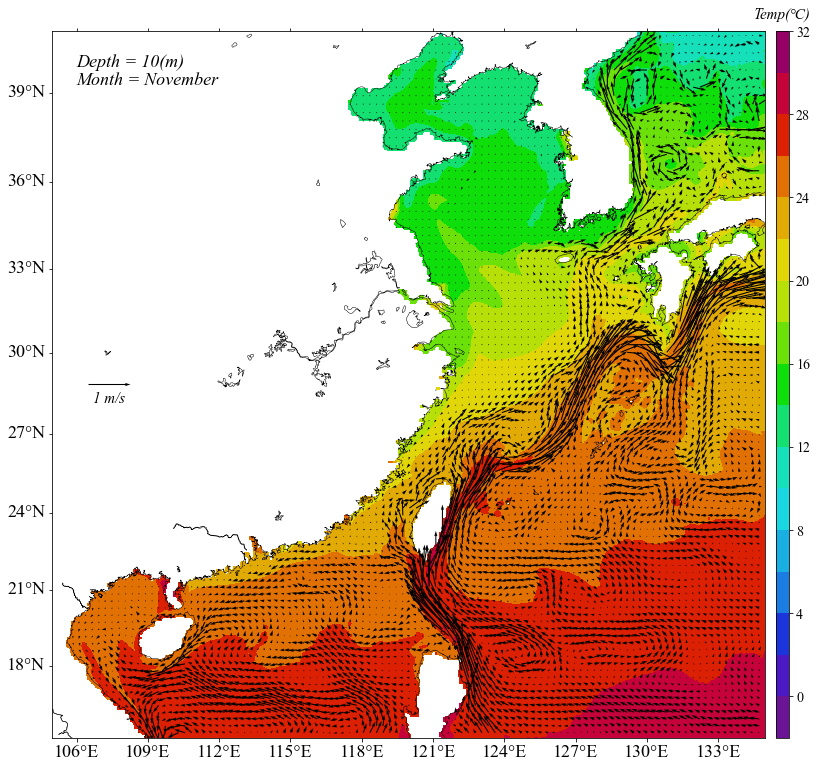

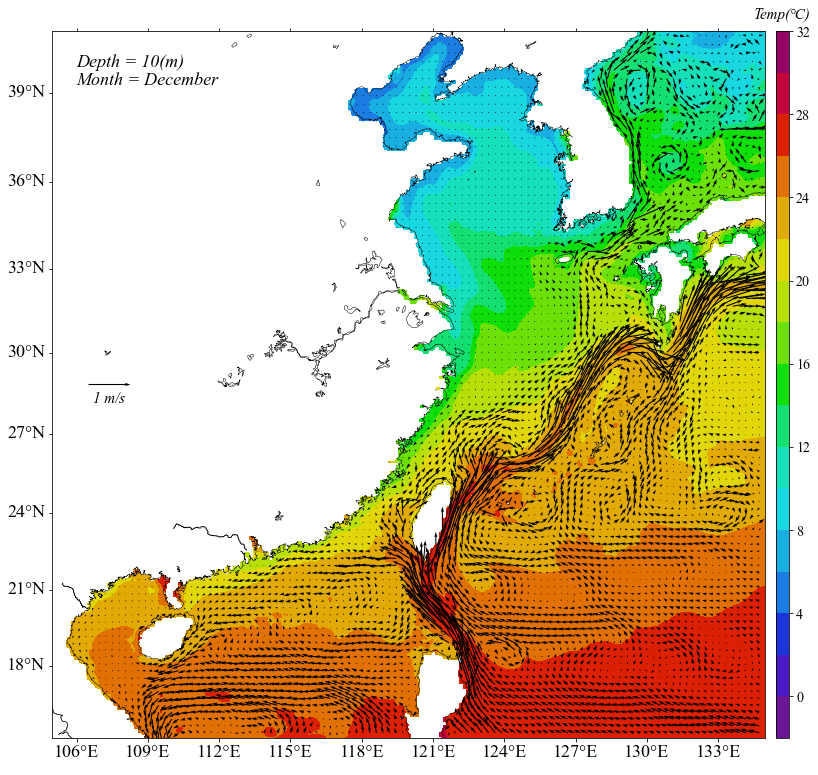

In [5]:
## exercise 1
#geographical projection of target area by basemap
lons,lats=np.meshgrid(lon,lat)
m = Basemap(projection='merc',llcrnrlat=15.1,urcrnrlat=41,\
            llcrnrlon=105,urcrnrlon=135,resolution='i')
x,y = m(lons,lats)
xpt,ypt = m(106,40)
xpt1,ypt1 = m(106,40-0.6)

#some settings for visualization
scale=17
interval=5
season=['January','February','March','April','May','June','July','August','september','October','November','December']

#Visualize the monthly 10m current and temperature distribution and save
interp_depth=10
for i in range(0,12):
    zt=zslice(temp[i,::-1,:,:], z[::-1]*-1, interp_depth*-1)
    zu=zslice(u[i,::-1,:,:], z[::-1]*-1, interp_depth*-1)
    zv=zslice(v[i,::-1,:,:], z[::-1]*-1, interp_depth*-1)

    fig =plt.figure(figsize = (15,13))
    ax = plt.axes()
    font2={'family':'Times New Roman','style':'italic','size':15}
    plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
    clevs = np.arange(-2,32+2,2)
    cs = m.contourf(x,y,zt,clevs,cmap=cmaps.NCV_banded)
    h=m.quiver(x[0:-1:interval,0:-1:interval],y[0:-1:interval,0:-1:interval],zu[0:-1:interval,0:-1:interval]\
                ,zv[0:-1:interval,0:-1:interval],width=0.0015,scale=scale)
    ax.quiverkey(h,X=0.08,Y=0.5,U=1,angle=0,label='1 m/s',labelpos='S',color='k',fontproperties=font2)
    m.drawcoastlines(linewidth=0.5)
    set_lonlat(m, range(106, 135, 3), range(15, 41, 3), [0, 0, 0, 1], [1, 0, 0, 0], 18)
    axbar=fig.add_axes([ax.get_position().x0+0.67,ax.get_position().y0,0.012,ax.get_position().height])
    cb=fig.colorbar(cs,cax=axbar,pad=0.02,shrink=1)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_title(label='Temp(℃)',loc='center',fontdict=font2,y=1.01)
    ax.text(xpt1,ypt1,'Month = '+season[i],fontsize=18,color='k',ha='left',va='center',fontproperties=font2)
    ax.text(xpt,ypt,'Depth = '+str(interp_depth)+'(m)',fontsize=18,color='k',ha='left',va='center',fontproperties=font2)
    savename ='C:/Users/yt/Desktop/pom18_w/figure10/'+str(i+1)+'.jpg'
    plt.savefig(savename,dpi=300, bbox_inches='tight')

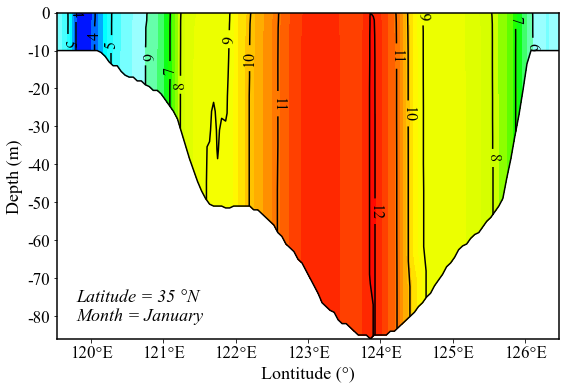

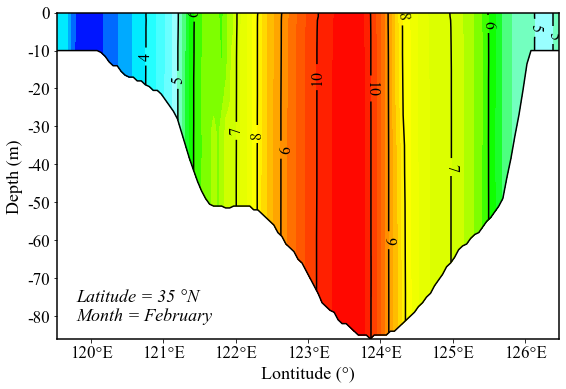

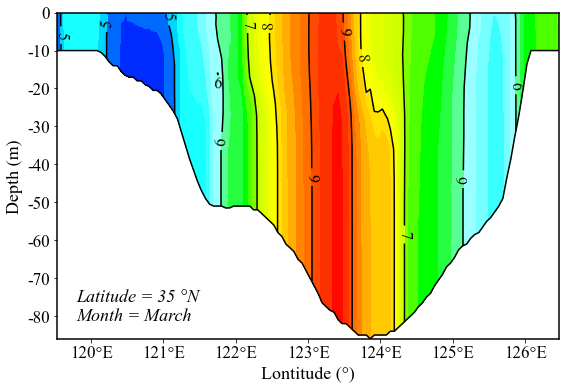

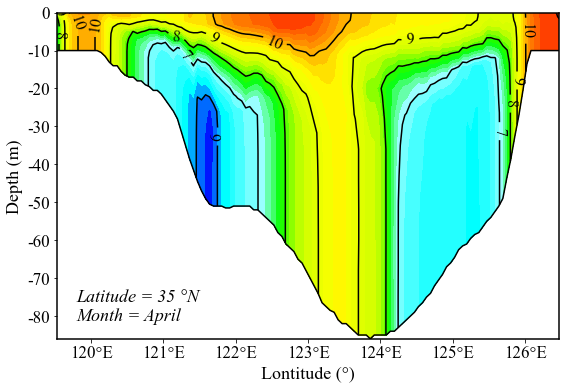

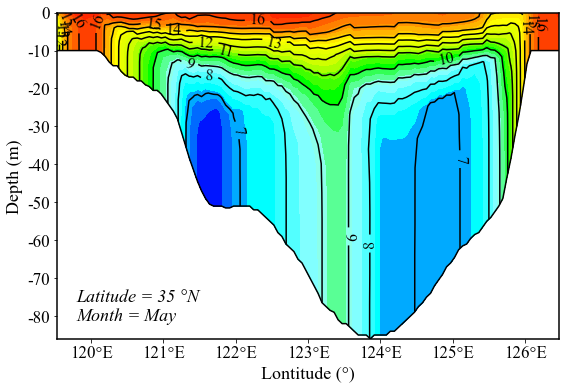

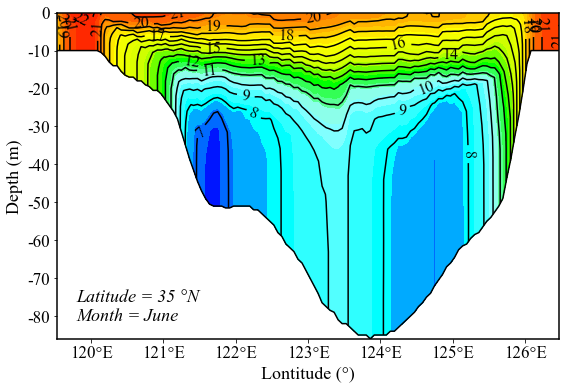

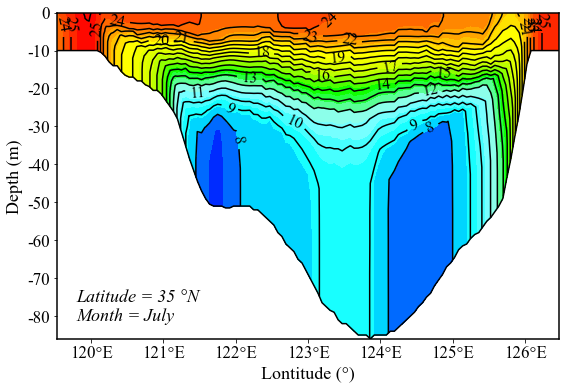

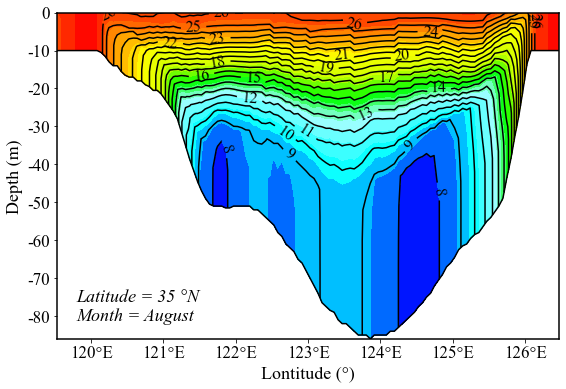

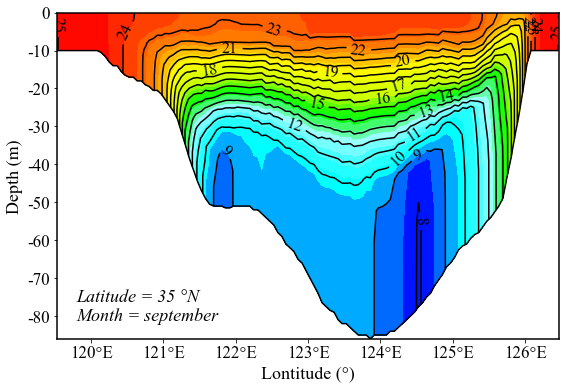

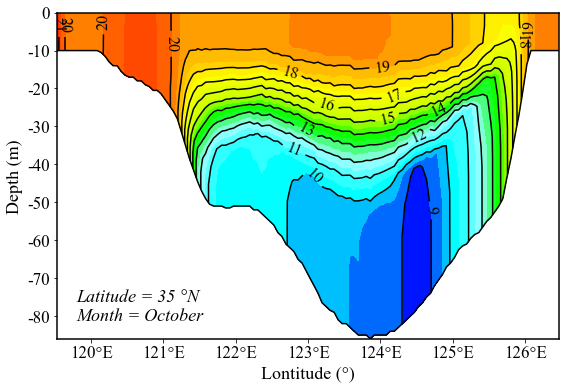

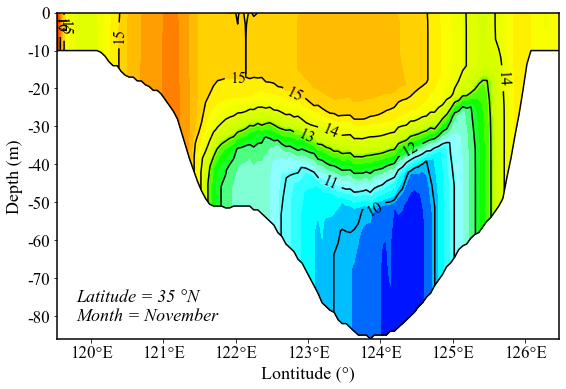

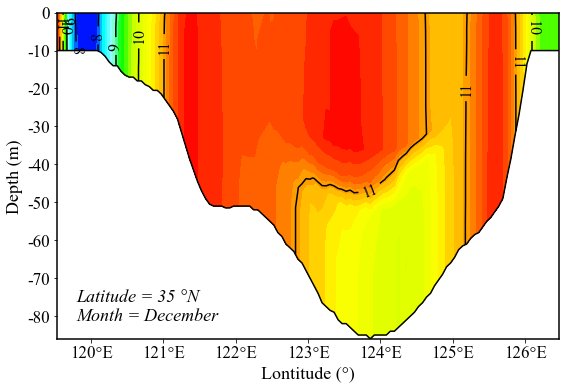

In [7]:
## exercise 2

#get longitude range
lon_range=lon[np.where((lon>119.5)&(lon<126.5))]

#do the vertical interpolation by xarray
dz = xr.DataArray(data=z,dims=("s","x","y"),coords={"s":s,"x": lat, "y": lon})
z_section=dz.interp(x=35,y=lon_range, method="linear").values
z_section[np.isnan(z_section)]=0

dt = xr.DataArray(data=temp,dims=("month","s","x","y"),coords={"month":np.arange(1,13,1),"s":s,"x": lat, "y": lon})
t_section=dt.interp(x=35,y=lon_range, method="linear").values

#Visualize the monthly profile of the 35°N temperature distribution and save
X=np.tile(lon_range, (len(s),1)) 
for i in range(0,12):
    t_section1=t_section[i,:,:]
    fig =plt.figure(figsize = (9,6))
    ax = plt.axes()
    ax.spines[['top','bottom','right','left']].set_linewidth('1.5')
    font2={'family':'Times New Roman','style':'italic','size':18}
    plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
    CS = ax.contourf(X,z_section*-1,t_section1,30,cmap=cmaps.BlAqGrYeOrRe)
    clevs2 = np.arange(4,27,1)
    cs = ax.contour(X,z_section*-1,t_section1,clevs2,colors='k')
    ax.clabel(cs, inline=True, fontsize=16)
    ax.plot(lon_range,z_section[-1,:]*-1,'k')
    ax.set_xticks(np.arange(120,127,1))
    ax.set_xticklabels([str(i)+'°E' for i in np.arange(120,127,1)],fontsize=17) 
    ax.set_yticks(np.arange(-80,10,10))
    ax.set_yticklabels(np.arange(-80,10,10),fontsize=17)
    ax.set_ylabel('Depth (m)',fontsize=18)
    ax.set_xlabel('Lontitude (°)',fontsize=18)
    ax.text(119.8,-75,'Latitude = 35 °N',fontsize=18,color='k',ha='left',va='center',fontproperties=font2)
    ax.text(119.8,-80,'Month = '+season[i],fontsize=18,color='k',ha='left',va='center',fontproperties=font2)
    savename ='C:/Users/yt/Desktop/pom18_w/contour35_t/'+str(i+1)+'.jpg'
    plt.savefig(savename,dpi=300,bbox_inches='tight')